In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score

In [2]:
df = pd.read_csv("../data/processed/cleaned_data.csv")
X, y = df["clean_comment"], df["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
tokenizers = {
    "Count": CountVectorizer(),
    "TFIDF": TfidfVectorizer(),
    "Hashing": HashingVectorizer(n_features=5000, alternate_sign=False)
}

models = {
    "LogReg": LogisticRegression(max_iter=200),
    "NaiveBayes": MultinomialNB(),
    "SVM": LinearSVC()
}


In [5]:
# cross Validation
results = []
for tname, tok in tokenizers.items():
    for mname, model in models.items():
        pipe = Pipeline([("tok", tok), ("clf", model)])
        scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1_macro")
        results.append({
            "tokenizer": tname,
            "model": mname,
            "f1_mean": scores.mean(),
            "f1_std": scores.std()
        })
results_df = pd.DataFrame(results).sort_values("f1_mean", ascending=False)
results_df


,tokenizer,model,f1_mean,f1_std
2,Count,SVM,0.984915,0.000541
5,TFIDF,SVM,0.981718,0.000918
0,Count,LogReg,0.978978,0.001380
3,TFIDF,LogReg,0.959589,0.002466
8,Hashing,SVM,0.877370,0.002995
6,Hashing,LogReg,0.873381,0.002379
1,Count,NaiveBayes,0.802287,0.003639
7,Hashing,NaiveBayes,0.719989,0.001442
4,TFIDF,NaiveBayes,0.638994,0.000972


In [6]:
#Evaluate on test set
best = results_df.iloc[0]
pipe = Pipeline([
    ("tok", tokenizers[best.tokenizer]),
    ("clf", models[best.model])
])
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, preds))
print("Test F1 Macro:", f1_score(y_test, preds, average="macro"))


Test Accuracy: 0.9857971850854413
Test F1 Macro: 0.985563067077082


<Axes: xlabel='tokenizer'>

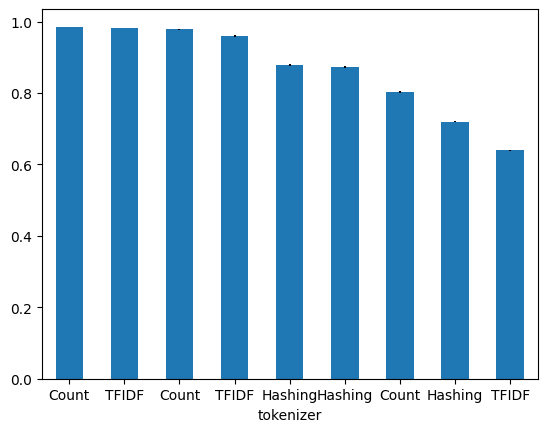

In [7]:
# visualize
results_df.plot.bar(x="tokenizer", y="f1_mean", yerr="f1_std", rot=0, legend=False)
